# MS2 Feature Evaluation

Comprehensive evaluation of MS2 features on full dataset with target-decoy analysis.


In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from alpharaw import register_all_readers
from alphabase.peptide.fragment import get_charged_frag_types
from peptdeep.rescore.fdr import calc_fdr

from dia_aspire_rescore.io import read_diann2
from dia_aspire_rescore.psm.matcher import DIAPeptideSpectrumMatcher
from dia_aspire_rescore.config import FineTuneConfig
from dia_aspire_rescore.finetuning import FineTuner
from dia_aspire_rescore.features import MS2FeatureGenerator
from dia_aspire_rescore.plot import plot_target_decoy_dist, plot_qvalues

register_all_readers()

# Create output directory
output_dir = Path('../output/ms2')
output_dir.mkdir(parents=True, exist_ok=True)


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/alpharaw/raw_access/pysciexwifffilereader.py:44: UserWarning: Dotnet-based dependencies could not be loaded. Sciex support is disabled.
  warnings.warn(


In [18]:
psm_df_all = read_diann2("../../data/raw/SYS026_RA957/DDA_SYSMHC_bynam/lib-base-result-first-pass.parquet")
psm_df_all = psm_df_all[psm_df_all['raw_name'] == '20200317_QE_HFX2_LC3_DIA_RA957_R01'].copy()
psm_df_all = psm_df_all.sort_values(by='nAA', ascending=True).reset_index(drop=True)
print(f"Loaded {len(psm_df_all)} PSMs")
print(f"Target: {(psm_df_all['decoy']==0).sum()}, Decoy: {(psm_df_all['decoy']==1).sum()}")


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/alphabase/psm_reader/psm_reader.py:342: UserWarning: Unknown modifications: {'Q(UniMod:1)'}. Precursors with unknown modifications will be removed.
  warnings.warn(


Loaded 169203 PSMs
Target: 87117, Decoy: 82086


In [19]:
psm_df_all

,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,fdr1_search1,fdr2_search1,fdr1_search2,fdr2_search2,mods,mod_sites,nAA,rt_norm,precursor_mz,ccs
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,YQYYHRYY,3,44.166344,44.104832,44.227886,0.0,1/sp|O96000|NDUBA_HUMAN,1/sp|O96000|NDUBA_HUMAN,,...,2.647732e-01,1.000000,0.0,0.0,,,8,0.369029,419.189212,0.0
1,20200317_QE_HFX2_LC3_DIA_RA957_R01,YDVKAPAM,2,57.876316,57.599941,57.937908,0.0,1/sp|P61247|RS3A_HUMAN,1/sp|P61247|RS3A_HUMAN,,...,2.811684e-01,0.000124,0.0,0.0,,,8,0.483581,447.723121,0.0
2,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPHTDFTL,1,83.991959,83.868828,84.237930,0.0,1/sp|Q9UBQ5|EIF3K_HUMAN,1/sp|Q9UBQ5|EIF3K_HUMAN,,...,1.248745e-02,0.000124,0.0,0.0,,,8,0.701789,943.488359,0.0
3,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPHTDFTL,2,83.974884,83.851768,84.220856,0.0,1/sp|Q9UBQ5|EIF3K_HUMAN,1/sp|Q9UBQ5|EIF3K_HUMAN,,...,3.598546e-04,0.000124,0.0,0.0,,,8,0.701646,472.247818,0.0
4,20200317_QE_HFX2_LC3_DIA_RA957_R01,ERVEPHQL,2,32.273998,32.181034,32.366127,0.0,1/sp|Q5SQI0|ATAT_HUMAN,1/sp|Q5SQI0|ATAT_HUMAN,,...,6.973431e-03,0.026246,0.0,0.0,,,8,0.269663,504.267073,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169198,20200317_QE_HFX2_LC3_DIA_RA957_R01,HAAAVNGDKGALQR,3,23.049833,22.955841,23.331867,0.0,1/sp|Q9Y283|INVS_HUMAN,1/sp|Q9Y283|INVS_HUMAN,,...,4.727965e-07,0.000124,0.0,0.0,,,14,0.192591,469.919896,0.0
169199,20200317_QE_HFX2_LC3_DIA_RA957_R01,SSFDSDHSSPFHVR,3,52.514473,52.359890,52.607216,0.0,1/sp|hsa_circ_0119979_0|hsa_circ_0119979_0,1/sp|hsa_circ_0119979_0|hsa_circ_0119979_0,,...,4.997472e-01,1.000000,0.0,0.0,,,14,0.438781,535.574454,0.0
169200,20200317_QE_HFX2_LC3_DIA_RA957_R01,EPAGTEWDPGASAR,2,53.388950,53.296055,53.543766,0.0,2/C4orf32_p.G32E_uc003iah.2|C4orf32/uc003iah.2,2/C4orf32_p.G32E_uc003iah.2|C4orf32/uc003iah.2,,...,1.000000e+00,1.000000,0.0,0.0,,,14,0.446087,722.328587,0.0
169201,20200317_QE_HFX2_LC3_DIA_RA957_R01,EEFQTTISKYFSAR,3,88.692657,88.600349,88.815552,0.0,1/sp|Q9UL46|PSME2_HUMAN,1/sp|Q9UL46|PSME2_HUMAN,,...,1.000000e+00,1.000000,0.0,0.0,,,14,0.741065,569.617660,0.0


In [20]:

# Select high-confidence PSMs for finetuning
psm_df_finetune = psm_df_all[
    psm_df_all['fdr1_search1'] < 0.01
].copy()
print(f"Selected {len(psm_df_finetune)} high-confidence PSMs for finetuning")


Selected 41817 high-confidence PSMs for finetuning


In [5]:

# Cell 4: Match MS2 for finetuning data
ms_files = {
    '20200317_QE_HFX2_LC3_DIA_RA957_R01': '../output/20200317_QE_HFX2_LC3_DIA_RA957_R01.mzML.hdf5',
}

matcher = DIAPeptideSpectrumMatcher(n_neighbors=0)
psm_df_finetune, _, matched_intensity_finetune, _ = matcher.match_ms2_multi_raw(
    psm_df_finetune, ms_files, 'hdf5'
)
print(f"Matched {len(psm_df_finetune)} PSMs for finetuning")


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]

Matched 38610 PSMs for finetuning


In [6]:

# Finetune MS2 model
config = FineTuneConfig(
    instrument='QE',
    nce=27,
    psm_num_to_train_ms2=min(8000, len(psm_df_finetune)),
    epoch_to_train_ms2=20,
    train_verbose=True
)

finetuner = FineTuner(config)
finetuner.load_pretrained('generic')
finetuner.train_ms2(psm_df_finetune, matched_intensity_finetune)
print("MS2 model finetuned successfully")


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/model/ms2.py:416: UserWarning: mask_modloss is deprecated and will be removed in the future. To mask the modloss fragments, the charged_frag_types should not include the modloss fragments.
  warnings.warn(


2025-12-08 20:03:47> 8104 PSMs for MS2 model training/transfer learning
2025-12-08 20:03:47> Training with fixed sequence length: 0
[Training] Epoch=1, lr=2e-05, loss=0.07840776480734349
[Training] Epoch=2, lr=3e-05, loss=0.07003474570810794
[Training] Epoch=3, lr=4e-05, loss=0.06425625160336494
[Training] Epoch=4, lr=5e-05, loss=0.060317892394959924
[Training] Epoch=5, lr=6e-05, loss=0.058774623274803164
[Training] Epoch=6, lr=7e-05, loss=0.05662648696452379
[Training] Epoch=7, lr=8e-05, loss=0.05565766990184784
[Training] Epoch=8, lr=9e-05, loss=0.054596390947699545
[Training] Epoch=9, lr=0.0001, loss=0.05267103873193264
[Training] Epoch=10, lr=0.0001, loss=0.05238328259438276
[Training] Epoch=11, lr=9.755282581475769e-05, loss=0.05198858641088009
[Training] Epoch=12, lr=9.045084971874738e-05, loss=0.05148908663541078
[Training] Epoch=13, lr=7.938926261462366e-05, loss=0.050907333567738536
[Training] Epoch=14, lr=6.545084971874738e-05, loss=0.05024307575076818
[Training] Epoch=15, lr

In [7]:
# Match MS2 for all data
psm_df_all_matched, fragment_mz_df, matched_intensity_df, matched_mz_err_df = matcher.match_ms2_multi_raw(
    psm_df_all, ms_files, 'hdf5'
)
print(f"Matched {len(psm_df_all)} PSMs for feature generation")


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

Matched 169203 PSMs for feature generation


In [8]:
# Generate MS2 features
frag_types = get_charged_frag_types(['b', 'y'], 2)
ms2_generator = MS2FeatureGenerator(
    model_mgr=finetuner.model_manager,
    frag_types=frag_types,
    spc_top_k=0,
)

psm_df_all = ms2_generator.generate(psm_df_all_matched, matched_intensity_df, matched_mz_err_df)
print(f"Generated {len(ms2_generator.feature_names)} MS2 features")


2025-12-08 20:06:01> Predicting MS2 ...


100%|██████████| 7/7 [00:43<00:00,  6.21s/it]


Generated 51 MS2 features


In [9]:
psm_df_all

,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,matched_yion_ratio,both_matched_pred_yion_num,both_matched_pred_yion_to_matched,both_matched_pred_yion_to_pred,matched_not_pred_yion_num,matched_not_pred_yion_ratio,pred_not_matched_yion_num,pred_not_matched_yion_ratio,matched_yion_rel_to_pred,pred_yion_rel_to_matched
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,YQYYHRYY,3,44.166344,44.104832,44.227886,0.0,1/sp|O96000|NDUBA_HUMAN,1/sp|O96000|NDUBA_HUMAN,,...,0.142857,1.0,0.500000,0.111111,1.0,0.500000,8.0,0.888889,0.481839,0.335081
1,20200317_QE_HFX2_LC3_DIA_RA957_R01,YDVKAPAM,2,57.876316,57.599941,57.937908,0.0,1/sp|P61247|RS3A_HUMAN,1/sp|P61247|RS3A_HUMAN,,...,0.214286,2.0,0.666667,0.333333,1.0,0.333333,4.0,0.666667,0.805005,0.510317
2,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPHTDFTL,1,83.991959,83.868828,84.237930,0.0,1/sp|Q9UBQ5|EIF3K_HUMAN,1/sp|Q9UBQ5|EIF3K_HUMAN,,...,0.285714,3.0,0.750000,0.750000,1.0,0.250000,1.0,0.250000,0.995084,0.992362
3,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPHTDFTL,2,83.974884,83.851768,84.220856,0.0,1/sp|Q9UBQ5|EIF3K_HUMAN,1/sp|Q9UBQ5|EIF3K_HUMAN,,...,0.357143,2.0,0.400000,1.000000,3.0,0.600000,0.0,0.000000,0.948350,1.000000
4,20200317_QE_HFX2_LC3_DIA_RA957_R01,ERVEPHQL,2,32.273998,32.181034,32.366127,0.0,1/sp|Q5SQI0|ATAT_HUMAN,1/sp|Q5SQI0|ATAT_HUMAN,,...,0.428571,4.0,0.666667,0.800000,2.0,0.333333,1.0,0.200000,0.661776,0.910811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169198,20200317_QE_HFX2_LC3_DIA_RA957_R01,HAAAVNGDKGALQR,3,23.049833,22.955841,23.331867,0.0,1/sp|Q9Y283|INVS_HUMAN,1/sp|Q9Y283|INVS_HUMAN,,...,0.576923,13.0,0.866667,0.866667,2.0,0.133333,2.0,0.133333,0.979435,0.910025
169199,20200317_QE_HFX2_LC3_DIA_RA957_R01,SSFDSDHSSPFHVR,3,52.514473,52.359890,52.607216,0.0,1/sp|hsa_circ_0119979_0|hsa_circ_0119979_0,1/sp|hsa_circ_0119979_0|hsa_circ_0119979_0,,...,0.115385,2.0,0.666667,0.133333,1.0,0.333333,13.0,0.866667,0.885871,0.070123
169200,20200317_QE_HFX2_LC3_DIA_RA957_R01,EPAGTEWDPGASAR,2,53.388950,53.296055,53.543766,0.0,2/C4orf32_p.G32E_uc003iah.2|C4orf32/uc003iah.2,2/C4orf32_p.G32E_uc003iah.2|C4orf32/uc003iah.2,,...,0.230769,5.0,0.833333,0.416667,1.0,0.166667,7.0,0.583333,0.625791,0.335678
169201,20200317_QE_HFX2_LC3_DIA_RA957_R01,EEFQTTISKYFSAR,3,88.692657,88.600349,88.815552,0.0,1/sp|Q9UL46|PSME2_HUMAN,1/sp|Q9UL46|PSME2_HUMAN,,...,0.038462,1.0,1.000000,0.062500,0.0,0.000000,15.0,0.937500,1.000000,0.027745


<Axes: xlabel='spc', ylabel='Density'>

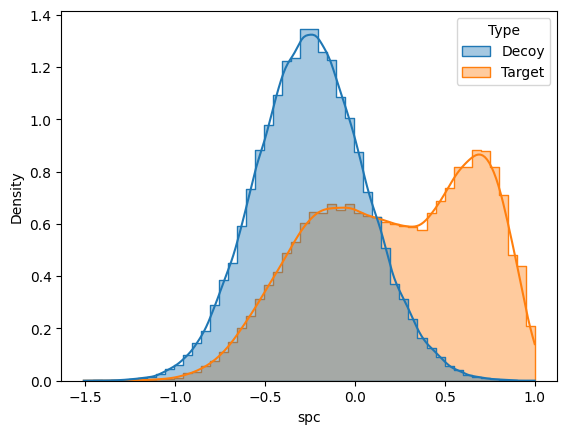

In [10]:
plot_target_decoy_dist(psm_df_all, metric='spc')

In [11]:
psm_df_all[ms2_generator.feature_names].describe(percentiles=[.25, .5, .75, .9, .95, .99])

,cos,sa,spc,pcc,cos_bion,sa_bion,spc_bion,pcc_bion,cos_yion,sa_yion,...,matched_yion_ratio,both_matched_pred_yion_num,both_matched_pred_yion_to_matched,both_matched_pred_yion_to_pred,matched_not_pred_yion_num,matched_not_pred_yion_ratio,pred_not_matched_yion_num,pred_not_matched_yion_ratio,matched_yion_rel_to_pred,pred_yion_rel_to_matched
count,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,...,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000,169203.000000
mean,0.453771,0.341881,-0.009167,0.380000,0.527075,0.413109,0.107193,0.451005,0.473412,0.375689,...,0.231762,2.828413,0.665981,0.469720,1.099632,0.293878,3.487296,0.524985,0.715826,0.536794
std,0.323592,0.283326,0.451783,0.363234,0.357130,0.318242,0.493753,0.408545,0.371004,0.333835,...,0.155427,2.561836,0.333459,0.328549,1.201633,0.310255,2.768540,0.328994,0.360231,0.384613
min,0.000000,0.000000,-1.509031,-0.247993,0.000000,0.000000,-1.602941,-0.367612,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.169836,0.108647,-0.344709,0.057931,0.184933,0.118413,-0.253870,0.034633,0.112029,0.071470,...,0.125000,1.000000,0.500000,0.200000,0.000000,0.000000,1.000000,0.250000,0.476788,0.146174
50%,0.383115,0.250298,-0.077713,0.291532,0.541421,0.364227,0.110423,0.450186,0.414045,0.271769,...,0.187500,2.000000,0.750000,0.400000,1.000000,0.250000,3.000000,0.600000,0.918378,0.548844
75%,0.746261,0.536306,0.317683,0.709874,0.894225,0.704545,0.471620,0.879250,0.878939,0.683496,...,0.312500,4.000000,1.000000,0.750000,2.000000,0.500000,6.000000,0.777778,1.000000,0.959938
90%,0.964731,0.830419,0.681452,0.958588,0.983656,0.884742,0.769118,0.981605,0.989017,0.905560,...,0.444444,7.000000,1.000000,1.000000,3.000000,0.750000,7.000000,1.000000,1.000000,1.000000
95%,0.986761,0.896295,0.794355,0.984667,0.994285,0.931908,0.926471,0.993699,0.996886,0.949746,...,0.562500,8.000000,1.000000,1.000000,3.000000,1.000000,8.000000,1.000000,1.000000,1.000000
99%,0.996521,0.946885,0.923937,0.996137,0.999664,0.983508,1.000000,0.999673,0.999983,0.996270,...,0.687500,11.000000,1.000000,1.000000,5.000000,1.000000,10.000000,1.000000,1.000000,1.000000


In [ ]:
for feature in ms2_generator.feature_names:
    print(f"Evaluating {feature}...")
    psm_df_eval = calc_fdr(psm_df_all.copy(), score_column=feature)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    use_kde = True  
    # if the feature str contains 'matched', do not use kde
    if 'mathced' in feature:
        use_kde = False
    plot_target_decoy_dist(psm_df_eval, feature, ax=axes[0], kde=use_kde)
    axes[0].set_title(f'{feature} - Target/Decoy Distribution')
    
    threshold = 0.1
    if psm_df_eval['fdr'].min() > 0.1:
        threshold = 0.5
    plot_qvalues(psm_df_eval['fdr'], threshold=threshold, ax=axes[1])
    axes[1].set_title(f'{feature} - Discoveries at FDR')
    plt.tight_layout()
    
    pdf_path = output_dir / f'{feature}_evaluation.pdf'
    plt.savefig(pdf_path, bbox_inches='tight')
    plt.close()

print(f"\nAll evaluations saved to {output_dir}")

Evaluating cos...
Evaluating sa...
Evaluating spc...
Evaluating pcc...
Evaluating cos_bion...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating sa_bion...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating spc_bion...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating pcc_bion...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating cos_yion...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating sa_yion...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating spc_yion...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating pcc_yion...
Evaluating merr_weighted_frag_score...
Evaluating pred_weighted_frag_score...
Evaluating merr_weighted_bion_score...
Evaluating pred_weighted_bion_score...
Evaluating merr_weighted_yion_score...
Evaluating pred_weighted_yion_score...
Evaluating matched_frag_num...
Evaluating matched_frag_ratio...
Evaluating both_matched_pred_frag_num...
Evaluating both_matched_pred_frag_to_matched...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating both_matched_pred_frag_to_pred...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating matched_not_pred_frag_num...
Evaluating matched_not_pred_frag_ratio...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating pred_not_matched_frag_num...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating pred_not_matched_frag_ratio...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating matched_frag_rel_to_pred...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating pred_frag_rel_to_matched...
Evaluating matched_bion_num...
Evaluating matched_bion_ratio...
Evaluating both_matched_pred_bion_num...
Evaluating both_matched_pred_bion_to_matched...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating both_matched_pred_bion_to_pred...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating matched_not_pred_bion_num...
Evaluating matched_not_pred_bion_ratio...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating pred_not_matched_bion_num...
Evaluating pred_not_matched_bion_ratio...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating matched_bion_rel_to_pred...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating pred_bion_rel_to_matched...
Evaluating matched_yion_num...
Evaluating matched_yion_ratio...
Evaluating both_matched_pred_yion_num...
Evaluating both_matched_pred_yion_to_matched...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating both_matched_pred_yion_to_pred...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating matched_not_pred_yion_num...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating matched_not_pred_yion_ratio...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating pred_not_matched_yion_num...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating pred_not_matched_yion_ratio...


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


Evaluating matched_yion_rel_to_pred...
Evaluating pred_yion_rel_to_matched...

All evaluations saved to output/ms2


In [13]:
df_check= psm_df_all[['sa_yion', 'decoy']]
df_check

,sa_yion,decoy
0,0.335857,1
1,0.582111,0
2,0.989702,0
3,0.936599,0
4,0.278713,0
...,...,...
169198,0.762225,0
169199,0.091697,1
169200,0.111912,1
169201,0.053902,1


In [14]:
df_check = calc_fdr(df_check, 'sa_yion')
df_check.head(100)

/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum


,sa_yion,decoy,fdr
80,1.0,1,0.154732
297,1.0,1,0.154732
362,1.0,1,0.154732
381,1.0,1,0.154732
419,1.0,1,0.154732
...,...,...,...
25324,1.0,1,0.154732
25627,1.0,1,0.154732
25662,1.0,1,0.154732
25818,1.0,1,0.154732


In [15]:
# check how many targets and how many decoys when sa_yion is 1
df_check[df_check['sa_yion'] == 1]
# number of targets and decoys when sa_yion is 1
df_check[df_check['sa_yion'] == 1]['decoy'].value_counts()
# number of targets and decoys when sa_yion is 0
df_check[df_check['sa_yion'] == 0]['decoy'].value_counts()




decoy
1    12185
0     6166
Name: count, dtype: int64

In [ ]:
summary = []
for feature in ms2_generator.feature_names:
    psm_df_eval = calc_fdr(psm_df_all.copy(), feature)
    targets_01fdr = ((psm_df_eval['fdr'] <= 0.01) & (psm_df_eval['decoy'] == 0)).sum()
    summary.append({
        'feature': feature,
        'targets_at_1pct_fdr': targets_01fdr
    })

summary_df = pd.DataFrame(summary).sort_values('targets_at_1pct_fdr', ascending=False)
print("\nFeature Performance Summary (Targets at 1% FDR):")
print(summary_df)

# Save summary
summary_df.to_csv(output_dir / 'feature_summary.csv', index=False)

/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / targ


Feature Performance Summary (Targets at 1% FDR):
                              feature  targets_at_1pct_fdr
28           pred_frag_rel_to_matched                26925
22     both_matched_pred_frag_to_pred                25910
2                                 spc                22581
13           pred_weighted_frag_score                18680
20         both_matched_pred_frag_num                18094
12           merr_weighted_frag_score                14650
1                                  sa                13808
0                                 cos                13808
17           pred_weighted_yion_score                12708
16           merr_weighted_yion_score                12364
42         both_matched_pred_yion_num                12118
3                                 pcc                11259
19                 matched_frag_ratio                10796
41                 matched_yion_ratio                10267
18                   matched_frag_num                10078
40    